In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<ipython-input-4-c9dd88514181>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='Set2')


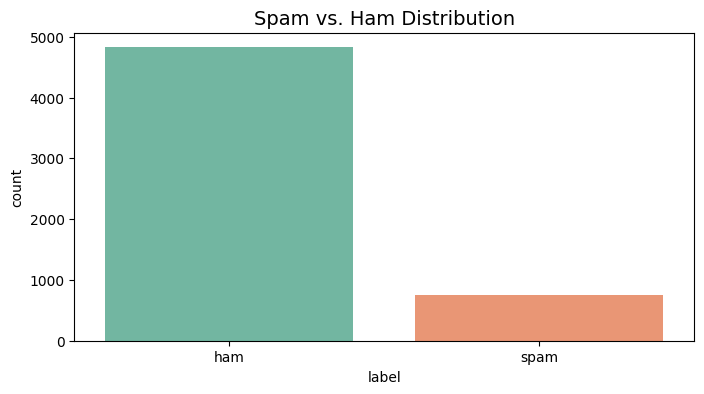

In [4]:
# Class distribution
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='label', palette='Set2')
plt.title("Spam vs. Ham Distribution", fontsize=14)
plt.show()

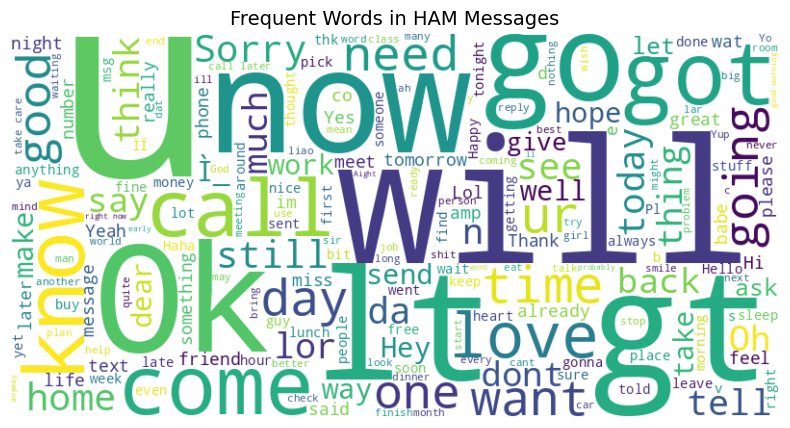

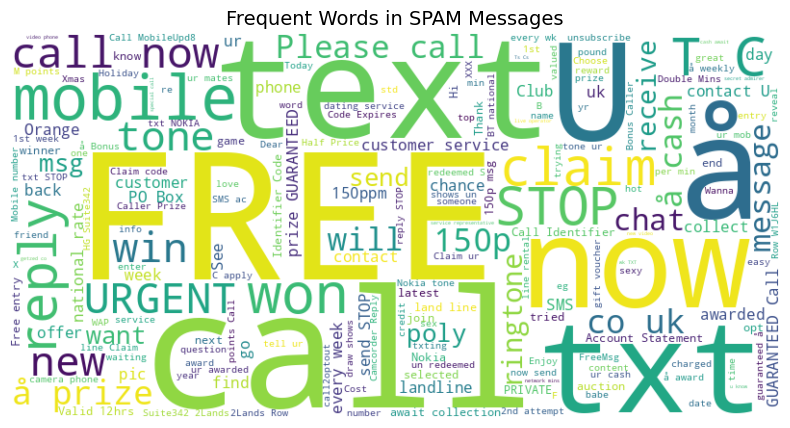

In [5]:
# Word clouds
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

ham_text = " ".join(df[df['label'] == 'ham']['text'])
spam_text = " ".join(df[df['label'] == 'spam']['text'])
plot_wordcloud(ham_text, "Frequent Words in HAM Messages")
plot_wordcloud(spam_text, "Frequent Words in SPAM Messages")

In [6]:
# Clean text
nltk.download('stopwords')
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_text'] = df['text'].apply(clean_text)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,label,text,cleaned_text
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


<ipython-input-8-ec446aba9a72>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[0] for word in top_ham], y=[word[1] for word in top_ham], ax=axes[0], palette='viridis')
<ipython-input-8-ec446aba9a72>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[0] for word in top_spam], y=[word[1] for word in top_spam], ax=axes[1], palette='magma')


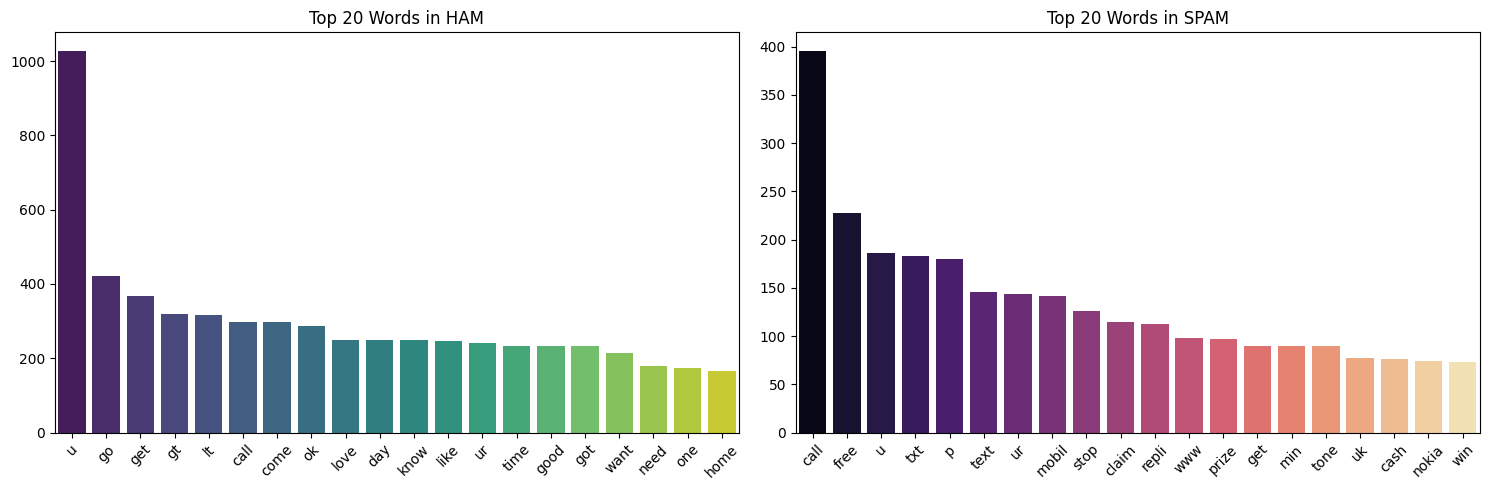

In [8]:
# Top words after cleaning
from collections import Counter
def get_top_words(text_series, n=20):
    all_words = " ".join(text_series).split()
    return Counter(all_words).most_common(n)

top_ham = get_top_words(df[df['label'] == 'ham']['cleaned_text'])
top_spam = get_top_words(df[df['label'] == 'spam']['cleaned_text'])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x=[word[0] for word in top_ham], y=[word[1] for word in top_ham], ax=axes[0], palette='viridis')
axes[0].set_title("Top 20 Words in HAM")
axes[0].tick_params(axis='x', rotation=45)
sns.barplot(x=[word[0] for word in top_spam], y=[word[1] for word in top_spam], ax=axes[1], palette='magma')
axes[1].set_title("Top 20 Words in SPAM")
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_text']).toarray()
y = df['label'].map({'ham': 0, 'spam': 1})

In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Train Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

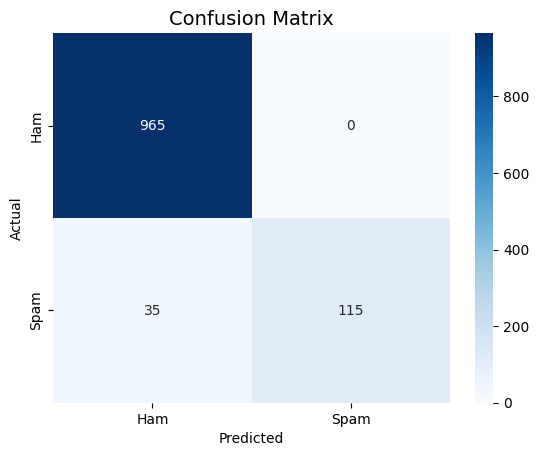

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.77      0.87       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.93      1115
weighted avg       0.97      0.97      0.97      1115



In [13]:
 # Evaluation
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix", fontsize=14)
plt.show()

print(classification_report(y_test, y_pred))